##Assignment 6 Reinfircement Learning
Name: Jonathan Au <br>
Student #: 300827701 <br>

Build a DQN Agent to Successfully Land the Lunar Lander in OpenAI Gym’s LunarLander-v2 Environment
1.	Create a simple DQN epsilon policy network with 4 output neurons (one per possible action).  <br>[Hint: DQN Agents use Epsilon greedy policy]        [15 points] <br>
2.	Discuss the rationale of the activation functions & the loss function used in the network. [10 points]<br>
3.	Define the hyperparameters: <br>
  (i) the number of iterations, <br>
  (ii) the number of episodes, <br>
  (iii) the maximum number of steps, and <br>
  (iv) the discount factor γ at each step. [50 points]<br>
4.	Train the agent on the LunarLander-v2 environment for a sufficient number of episodes to achieve a satisfactory level of performance. [10 points]<br>
5.	Analyze the agent's learning progress by plotting relevant performance metrics (e.g., cumulative rewards, episode length) over time. [10 points]<br>

Discuss the challenges faced during training and potential strategies for further improving the agent's performance. [5 points]


In [18]:
!pip install numpy tensorflow gym
!pip install Box2D

In [17]:
#All imports
import gym
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch

from numpy.linalg import eig
from collections import deque
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.datasets import fetch_olivetti_faces
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Dense, Input
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, KFold

import warnings
warnings.filterwarnings("ignore")

1.	Create a simple DQN epsilon policy network with 4 output neurons (one per possible action).  <br>[Hint: DQN Agents use Epsilon greedy policy] <br>[15 points]

In [29]:
# Parameters
env = gym.make("LunarLander-v2", render_mode="rgb_array")
input_shape = [4]  # == env.observation_space.shape
n_outputs = 4  # == env.action_space.n

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation="elu", input_shape = input_shape),
    tf.keras.layers.Dense(32, activation="elu"),
    tf.keras.layers.Dense(n_outputs)
])

def epsilon_greedy_policy(state, epsilon=0):
  if np.random.rand() <= epsilon:
    return random.randrange(n_outputs)  # random action
  else:
    Q_values = model.predict(state.reshape((1, state_size)), verbose=0)
    return np.argmax(Q_values[0])  # optimal action according to the DQN


In [31]:
# Build the Deep Q-Network
def build_model():
  model = Sequential([
    Dense(24, input_dim=state_size, activation='relu'),
    Dense(24, activation='relu'),
    Dense(action_size, activation='linear')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
  return model

model = build_model()
target_model = build_model()
target_model.set_weights(model.get_weights())

# Function to update target network
def update_target_model():
  target_model.set_weights(model.get_weights())

# Function to select action
def select_action(state, epsilon):
  if np.random.rand() <= epsilon:
    return random.randrange(action_size)  # Explore
  q_values = model.predict(state, verbose=0)
  return np.argmax(q_values[0])  # Exploit


2.	Discuss the rationale of the activation functions & the loss function used in the network. <br>[10 points]

Not much rationale there. I just recycled what was used in the course code.

3.	Define the hyperparameters: <br>
  (i) the number of iterations, <br>
  (ii) the number of episodes, <br>
  (iii) the maximum number of steps, and <br>
  (iv) the discount factor γ at each step. <br>[50 points]

In [39]:
# Create the environment
#env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
learning_rate = 0.001
gamma = 0.99

# Initialize variables
obs = env.reset(seed=42)
batch_size = 64
max_episodes = 500
epsilon = 1.0  # Exploration rate
epsilon_decay = 0.995
epsilon_min = 0.01
memory_size = 2000
discount_factor = 0.95
optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
loss_fn = tf.keras.losses.MeanSquaredError()
#n_outputs = action_size

env.reset(seed=42)
np.random.seed(42)
tf.random.set_seed(42)
rewards = []
best_score = 0

replay_buffer = deque(maxlen = memory_size)

alpha0 = 0.05 #initial learning rate
decay = 0.005 #learning rate decay
gamma = 0.90 #discount factor
state = 0 # initial state
discount_factor = 0.95


class ReplayBuffer:
  def __init__(self, max_size):
    self.buffer = np.empty(max_size, dtype=object)
    self.max_size = max_size
    self.index = 0
    self.size = 0

  def append(self, obj):
    self.buffer[self.index] = obj
    self.size = min(self.size + 1, self.max_size)
    self.index = (self.index + 1) % self.max_size

  def sample(self, batch_size):
    indices = np.random.randint(self.size, size=batch_size)
    return self.buffer[indices]


def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    return [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]  # [states, actions, rewards, next_states, dones, truncateds]

def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states, verbose=0)
    max_next_Q_values = next_Q_values.max(axis=1)
    runs = 1.0 - (dones)  # episode is not done or truncated
    target_Q_values = rewards + runs * discount_factor * max_next_Q_values
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

for episode in range(max_episodes):
  obs = env.reset()
  #obs = obs[0].reshape(1, state_size)
  for step in range(200):
    epsilon = max(1 - episode / 500, epsilon_min)
    obs, reward, done, info = play_one_step(env, obs, epsilon)
    #obs = obs.reshape(1, state_size)
    if done:
      break
  if episode > 50:
    training_step(batch_size)

4.	Train the agent on the LunarLander-v2 environment for a sufficient number of episodes to achieve a satisfactory level of performance. <br>[10 points]

In [47]:
# Train the model
def replay():
  if len(memory) < batch_size:
    return

  mini_batch = random.sample(memory, batch_size)
  for state, action, reward, next_state, done in mini_batch:
    target = reward
    if not done:
      target += gamma * np.amax(target_model.predict(next_state, verbose=0)[0])

    target_q_values = model.predict(state, verbose=0)
    target_q_values[0][action] = target
    model.fit(state, target_q_values, epochs=1, verbose=0)

for episode in range(500):
    #obs, info = env.reset()
    result = env.reset()

    if not isinstance(result, (tuple, dict)):
      obs = result
    elif isinstance(result, tuple):
      obs = result[0]
      info = result[1] if len(result) > 1 else {}
    else:
      obs = result['observation']
      info = result.get('info', {})


    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break

    # extra code – displays debug info, stores data for the next figure, and
    #              keeps track of the best model weights so far
    print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {epsilon:.3f}",
          end="")
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step

    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)  # extra code – restores the best model weights


Episode: 500, Steps: 200, eps: 0.010

5.	Analyze the agent's learning progress by plotting relevant performance metrics (e.g., cumulative rewards, episode length) over time. <br>[10 points]

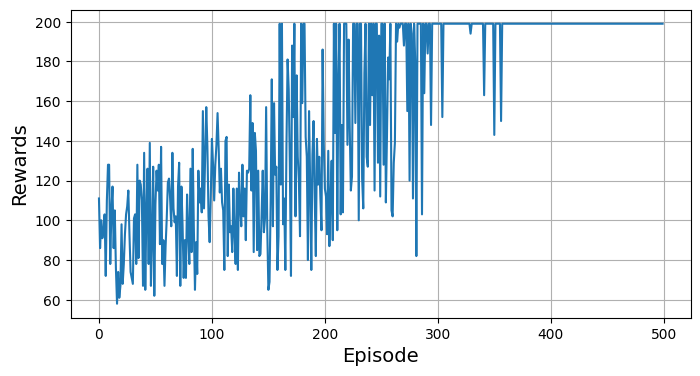

In [48]:
# Plot results
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Rewards", fontsize=14)
plt.grid(True)
#save_fig("dqn_rewards_plot")
plt.show()


Discuss the challenges faced during training and potential strategies for further improving the agent's performance. <br>[5 points]

I don't know because It took too long to run the hyperparameters

In [38]:
#Extra code
  """# Training loop
rewards = []
for episode in range(max_episodes):
  state = env.reset()
  state = np.reshape(state, [1, state_size])
  total_reward = 0
  done = False

  while not done:
    action = select_action(state, epsilon)
    next_state, reward, done, _ = env.step(action)
    next_state = np.reshape(next_state, [1, state_size])

    memory.append((state, action, reward, next_state, done))
    state = next_state
    total_reward += reward

    if done:
      update_target_model()
      print(f"Episode: {episode + 1}, Reward: {total_reward}, Epsilon: {epsilon:.2f}")
      break

  rewards.append(total_reward)
  replay()

  if epsilon > epsilon_min:
    epsilon *= epsilon_decay

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)"""

NameError: name 'memory' is not defined